<a target='_blank' href='https://colab.research.google.com/github/jay-gleeson/fintech-pairs-csuf/blob/main/archive/pairs_trading.ipynb'>
  <img src='https://colab.research.google.com/assets/colab-badge.svg' alt='Open In Colab'/>
</a>

# Import necessary dependencies for download stock data, cleaning data, and plotting.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os

# Required library for performing the Augmented Dickey-Fuller test.
from statsmodels.tsa.stattools import adfuller

# Create pandas DataFrame with various financial institutions using yfinance.

In [2]:
# Downloading data for American Express, Bank of America, Citibank, Capital One, Goldman Sachs,
# Chase, Mastercard, US Bank, Visa, and Wells Fargo from June 1, 2024 to June 1, 2025.
#
# Note: Only the daily adjusted close price column per each stock will be considered.
stocks = ['AXP','BAC','C','COF','GS','JPM','MA','USB','V','WFC'] # Note: Later, only Visa (V), Mastercard (MA), American Express (AXP), and Capital One (COF) are considered.
df = yf.download(stocks, start='2024-06-01', end='2025-06-01', auto_adjust=False, progress=False)['Adj Close']

# Clean dataframe by dropping any columns that are completely empty and forward-filling missing data.
df = df.dropna(axis=1, how='all')
df = df.ffill()

# Preview dataframe.
print(df.head())

Ticker             AXP        BAC          C         COF          GS  \
Date                                                                   
2024-06-03  234.230865  38.690689  59.893795  135.232727  445.632477   
2024-06-04  234.596725  38.496655  59.032917  132.629074  445.945892   
2024-06-05  232.065353  38.768299  59.748707  133.615295  452.194794   
2024-06-06  230.740356  38.516060  59.913143  134.493042  448.688385   
2024-06-07  230.067932  38.828400  59.758381  137.875854  445.563873   

Ticker             JPM          MA        USB           V        WFC  
Date                                                                  
2024-06-03  197.245499  440.597687  37.951439  268.428650  57.947166  
2024-06-04  194.645798  442.168396  37.215912  270.453918  57.322186  
2024-06-05  192.788849  444.047363  37.330536  272.518921  57.302658  
2024-06-06  192.446777  446.055542  37.273224  275.040588  56.374954  
2024-06-07  195.417877  447.159088  37.273224  276.658813  56.990166 

# Using greedy methods, find min, max, mean, variance, standard deviation, and interquartile range of stocks and download to csv for future use.

In [3]:
# Find length of each column.
#
# Function to find length of each column.
def length(data):
    count = 0
    for n in data:
        count += 1
    return count

# Sort each column in ascending order.
#
# Function to, upon call, sort a series of data in ascending order, using selection sort for simplicity.
def sort(data):
    data = data.copy()
    L = length(data)
    for i in range(L):
        index = i
        for j in range(i + 1, L):
            if data.iloc[j] < data.iloc[index]:
                index = j
        data.iloc[i], data.iloc[index] = data.iloc[index], data.iloc[i]
    return data


# Find minimum and maximum of each stock.
#
# Function to find minimum daily adjusted close price.
def minimum(data):
    min = data.iloc[0]
    for n in data:
        if n < min:
            min = n
    return min

# Function to find maximum daily adjusted close price.
def maximum(data):
    max = data.iloc[0]
    for n in data:
        if n > max:
            max = n
    return max

# Find range of each stock.
#
# Function to find the range of each stock.
def spread_range(data):
    return maximum(data) - minimum(data)

# Find mean price of each stock.
#
# Function to find mean daily adjusted close price of each stock.
def mean(data):
    sum = 0
    for n in data:
        sum += n
    return sum / length(data)

# Find variance of each stock.
#
# Function to find variance of each stock.
def variance(data):
    m = mean(data)
    sum_dev = 0

    # Numerator of variance formula, find sum of squared deviations.
    for n in data:
        sum_dev += (n - m) ** 2
    return sum_dev / (length(data) - 1)  # Note: Sample variance.

# Find standard deviation of each stock.
#
# Function to find standard deviation of each stock.
def stddev(data):

    # Standard deviation is the square root of the variance.
    return variance(data) ** 0.5

# Find interquartile range of each stock.
# 
# Function to find interquartile range of each stock.
def iqr(data):
    data = sort(data)
    L = length(data)

    # Interpolation function to find quartiles, using linear interpolation between adjacent sorted values. 
    def interpolate(quartile):
        pos = quartile * (L - 1)
        low = int(pos)
        
        # Function to find the minimum of two values.
        def minimum(a, b):
            if a < b:
                return a
            else:
                return b

        # Set high index to the next index.
        high = minimum(low + 1, L - 1)
        return data.iloc[low] + (data.iloc[high] - data.iloc[low]) * (pos - low)

    return interpolate(0.75) - interpolate(0.25)  # Return interquartile range, the 75th percentile minus the 25th percentile.

In [4]:
# Combine statistics and print to console.
#
# Create dataframe with columns as the tickers and the rows as the statistics.
stats = pd.DataFrame(columns=stocks, index=['Min','Max','Range','Mean','Variance','Std Dev', 'IQR'])

# Iterate through stocks and compute each statistic.
for ticker in stocks:
    data = df[ticker]
    stats[ticker] = [minimum(data), maximum(data), spread_range(data), mean(data), variance(data), stddev(data), iqr(data)]

# Print statistics.
print(stats)

# Save statistics to file directory.
try:
    filename = 'stats.csv'
    stats.to_csv(filename)

    # Get the full absolute path.
    full_path = os.path.abspath(filename)
    print(f"\nFile successfully saved to: {full_path}\n")
except Exception as e:
    print(f"\nAn error occurred while saving the file: {e}\n")


                 AXP        BAC          C         COF           GS  \
Min       219.705154  34.188526  54.796139  129.611176   435.142487   
Max       324.791748  47.162685  83.958618  209.152359   665.555786   
Range     105.086594  12.974159  29.162479   79.541183   230.413300   
Mean      271.134521  41.561109  66.764779  166.245341   535.360602   
Variance  731.813979   9.657267  51.978121  533.708798  3614.875234   
Std Dev    27.052061   3.107614   7.209585   23.102138    60.123832   
IQR        45.743637   5.572601  10.505775   41.069885   101.038147   

                 JPM           MA        USB            V        WFC  
Min       187.188721   427.719788  36.400002   251.908737  50.744259  
Max       278.236206   586.409973  52.475636   367.899994  80.577927  
Range      91.047485   158.690186  16.075634   115.991257  29.833668  
Mean      229.741910   508.671905  44.047664   306.040483  65.678648  
Variance  563.343298  1779.122252  15.500028  1129.054061  74.942861  
Std D

# Compute pearson correlation, spearman correlation, and kendall correlation.
# Then, find which two stocks are most correlated with each other using each method.

In [5]:
# Function to compute and export correlation matrix and heatmap.
def get_matrix(data, stocks, corr, filename_prefix, title):
    matrix = pd.DataFrame(index=stocks, columns=stocks, dtype=float)
    for i in stocks:
        for j in stocks:
            if stocks.index(j) >= stocks.index(i):
                matrix.loc[i, j] = corr(data[i], data[j])
            else:
                matrix.loc[i, j] = np.nan
    plt.figure(figsize=(10, 8))
    sb.heatmap(matrix, annot=True, cmap='Spectral')
    plt.title(f'{title} Correlation Heatmap')

    # Save heatmap to file directory.
    try:
        heatmap_filename = f'{filename_prefix}_heatmap'
        matrix.to_csv(heatmap_filename + '.csv')
        
        # Get the full absolute path.
        print(f"Heatmap CSV successfully saved to: {os.path.abspath(heatmap_filename + '.csv')}\n")
    except Exception as e:
        print(f"An error occurred while saving the file: {e}\n")
    plt.show()
    plt.close()

Heatmap CSV successfully saved to: c:\Users\jayja\OneDrive\Documents\GitHub\fintech-pairs-csuf\archive\pearson_heatmap.csv



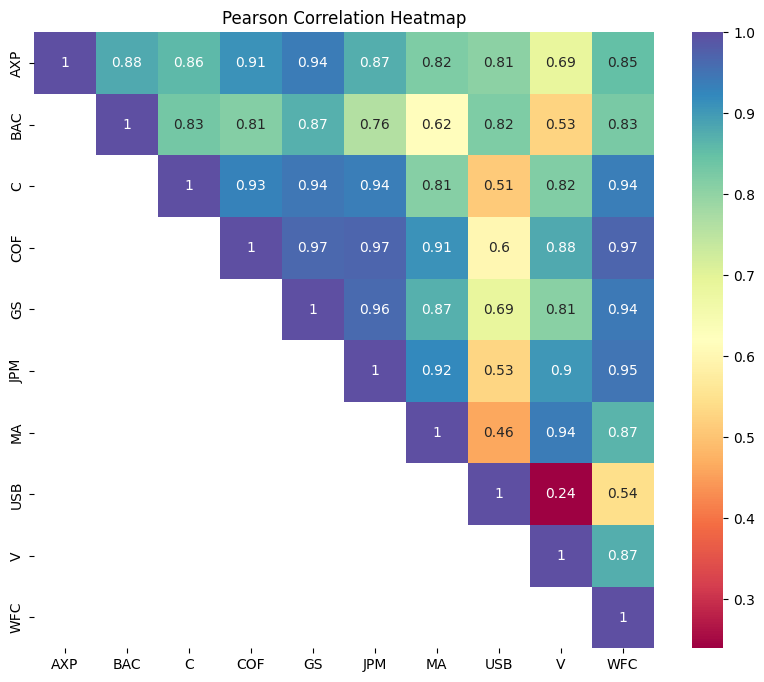

In [6]:
# Find pearson correlation coefficient between each stock.
#  
# Function to find pearson correlation coefficient between each stock.
def pearson_corr(x, y):
    L = length(x)
    meanx = mean(x)
    meany = mean(y)
    covariancexy = 0
    variancex = 0
    variancey = 0

    # Formula for pearson correlation coefficient is covariance divided by the product of the standard deviations.
    for n in range(L):
        covariancexy += (x.iloc[n] - meanx) * (y.iloc[n] - meany)
        variancex += (x.iloc[n] - meanx) ** 2
        variancey += (y.iloc[n] - meany) ** 2
    return covariancexy / ((variancex * variancey) ** 0.5)

# Compute and save pearson correlation.
get_matrix(df, stocks, pearson_corr, 'pearson', 'Pearson')

Heatmap CSV successfully saved to: c:\Users\jayja\OneDrive\Documents\GitHub\fintech-pairs-csuf\archive\spearman_heatmap.csv



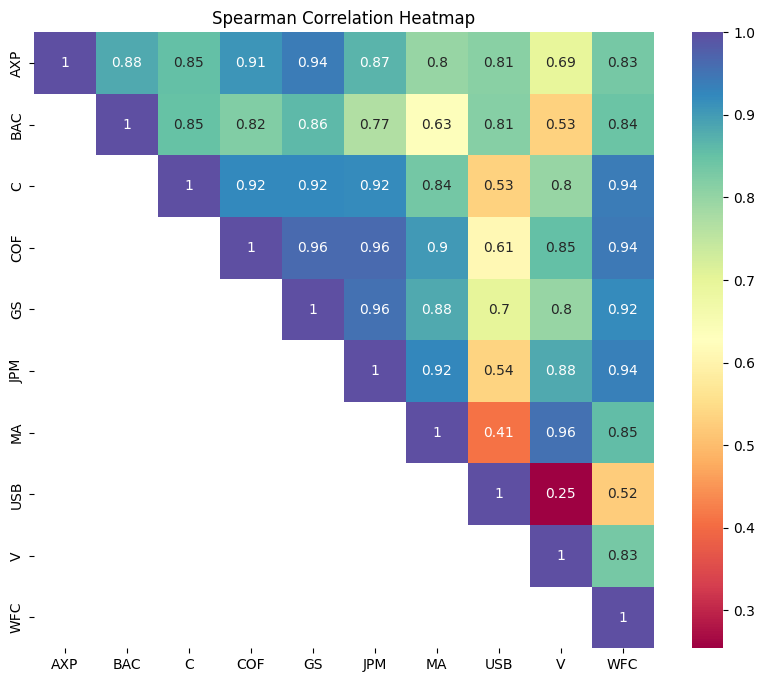

In [7]:
# Find spearman correlation coefficient between each stock.
#  
# Function to find spearman correlation coefficient between each stock.
def spearman_corr(x, y):

    # Function to rank data, using average ranks for ties.
    def rank(data):
        L = length(data)
        data = pd.Series([[data.iloc[n], n] for n in range(L)])
        data = sort(data)
        rank = [0] * L
        i = 0
        while i < L:
            val = data.iloc[i][0]
            j = i
            while j + 1 < L and data.iloc[j + 1][0] == val:
                j += 1
            avg_rank = (i + j + 2) / 2
            for k in range(i, j + 1):
                rank[data.iloc[k][1]] = avg_rank
            i = j + 1
        return pd.Series(rank, index=x.index)

    # Rank the data and compute pearson correlation on the ranks.
    rankx = rank(x)
    ranky = rank(y)
    return pearson_corr(rankx, ranky)

# Compute and save spearman correlation.
get_matrix(df, stocks, spearman_corr, 'spearman', 'Spearman')

Heatmap CSV successfully saved to: c:\Users\jayja\OneDrive\Documents\GitHub\fintech-pairs-csuf\archive\kendall_heatmap.csv



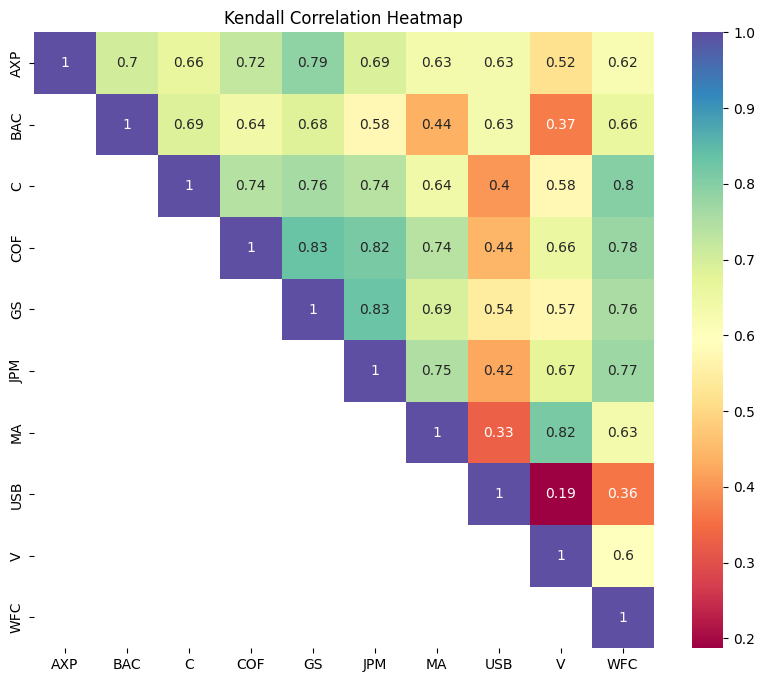

In [8]:
# Find kendall correlation coefficient between each stock.
#  
# Function to find kendall correlation coefficient between each stock.
def kendall_corr(x, y):
    L = length(x)
    concordant = 0
    discordant = 0

    # Formula for kendall correlation coefficient is the difference between the number of concordant and discordant pairs divided by the total number of pairs.
    for i in range(L):
        for j in range(i + 1, L):
            if (x.iloc[i] - x.iloc[j]) * (y.iloc[i] - y.iloc[j]) > 0:
                concordant += 1
            elif (x.iloc[i] - x.iloc[j]) * (y.iloc[i] - y.iloc[j]) < 0:
                discordant += 1
    return (concordant - discordant) / ((L * (L - 1)) / 2)

# Downsample the dataframe to speed up computation, taking 20% of the data.
#
# Function to downsample the dataframe by a given step.
def downsample_df(data, step):
    return data.iloc[::step].copy()

# Downsample the dataframe to speed up computation.
df_kendall = downsample_df(df, step=5)

# Compute and save kendall correlation.
get_matrix(df_kendall, stocks, kendall_corr, 'kendall', 'Kendall')

In [9]:
# Function to get the names of the stocks in the pair.
def get_stock_names(pair):
    stock_names = {
        'V': 'Visa',
        'MA': 'Mastercard',
        'AXP': 'American Express',
        'COF': 'Capital One'
    }
    namea = stock_names.get(pair[0], pair[0])
    nameb = stock_names.get(pair[1], pair[1])
    return namea, nameb

In [10]:
# Given all correlation methods, find the most correlated pairs of stocks.
#
# Function to find the most correlated pairs of credit network stocks, Visa, Mastercard, American Express, and Capital One.
def greatest_corr(stocks, method):
    
    # Only consider stocks in new_stocks.
    relevant_stocks = [n for n in stocks if n in new_stocks]

    # Find the greatest correlation by reading the previously saved correlation CSV files.
    corr_csv = f'{method.lower()}_heatmap.csv'
    pair = None
    max_corr = None
    if os.path.exists(corr_csv):
        corr_df = pd.read_csv(corr_csv, index_col=0)
        for i in relevant_stocks:
            for j in relevant_stocks:
                if i != j:
                    val = float(corr_df.loc[i, j])
                    if (max_corr is None) or (val > max_corr):
                        max_corr = val
                        pair = (i, j)
        if pair:

            # Put the stock with the lower average daily adjusted close price first in the pair for consistency.
            if os.path.exists('stats.csv'):
                stats_df = pd.read_csv('stats.csv', index_col=0)
                means = {n: float(stats_df.loc['Mean', n]) for n in pair}
                if means[pair[0]] > means[pair[1]]:
                    pair = (pair[1], pair[0])

                # Get the names of the stocks in the pair.
                namea, nameb = get_stock_names(pair)

                # Print the most correlated pair with their names and correlation value.
                print(f"Most correlated pair ({method}): {namea} ({pair[0]}) and {nameb} ({pair[1]}) with correlation {max_corr}")
            else:
                print(f"Stats CSV file not found. Defaulting to original order: {pair} with correlation {max_corr}")
    else:
        print(f"Correlation CSV file '{corr_csv}' not found.")
    return pair

# Only consider stocks in new_stocks.
new_stocks = ['V', 'MA', 'AXP', 'COF'] # Note: Discover (DFS) was acquired by Capital One (COF).

# Return the most correlated pairs of stocks for each correlation method.
print("Best correlated pairs by method:")
pearson_pair = greatest_corr(stocks, 'Pearson')
spearman_pair = greatest_corr(stocks, 'Spearman')
kendall_pair = greatest_corr(stocks, 'Kendall')

Best correlated pairs by method:
Most correlated pair (Pearson): Visa (V) and Mastercard (MA) with correlation 0.940509990378486
Most correlated pair (Spearman): Visa (V) and Mastercard (MA) with correlation 0.956240169545416
Most correlated pair (Kendall): Visa (V) and Mastercard (MA) with correlation 0.8155102040816327


In [11]:
# Set our new correlated pair to the spearman pair and perform cointegration on it.
pair = spearman_pair

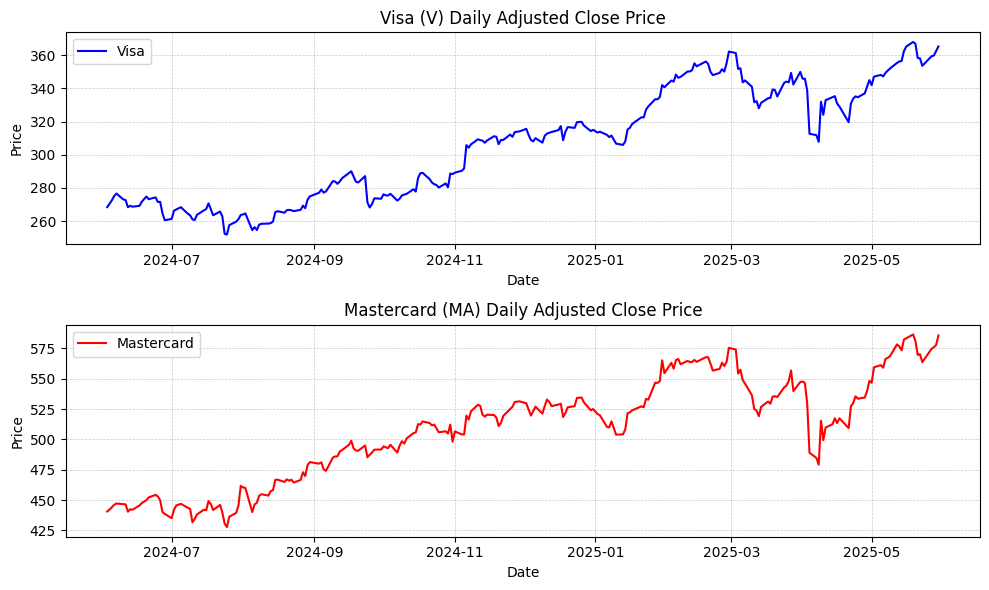

In [12]:
# Given the two most correlated pairs of stocks, plot two subplots of the daily adjusted close price of each stock in the pair.
def plot_pair(data, pair):

    # Get the names of the stocks in the pair.
    stocka, stockb = pair
    namea, nameb = get_stock_names(pair)
    
    # Plot the daily adjusted close price of each stock in the pair.
    # 
    # Stock A plots on the top.
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(data[stocka], label=namea, color='blue')
    plt.title(f'{namea} ({stocka}) Daily Adjusted Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Stock B plots on the bottom.
    plt.subplot(2, 1, 2)
    plt.plot(data[stockb], label=nameb, color='red')
    plt.title(f'{nameb} ({stockb}) Daily Adjusted Close Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Export the plot to a file.
    plt.tight_layout()
    plt.show()
    plt.close()
    
# Plot the most correlated pair based on Spearman correlation.
plot_pair(df, pair)

# Compute engle-granger cointegration.  *** TO BE COMPLETED

In [13]:
# Compute engle-granger cointegration.  *** TO BE COMPLETED
# 
# Function to normalize stock data on logarithmic scale.
def normalize(data, pair):
    stocka, stockb = pair
    a = data[stocka]
    b = data[stockb]
    norma = np.log(a)
    normb = np.log(b)
    return norma, normb

# Normalize the pair of stocks.
norma, normb = normalize(df, pair)

In [14]:
# Function to perform OLS regression on the normalized pair of stocks.
def ols(a, b):
    L = length(a)
    meana = mean(a)
    meanb = mean(b)
    num = 0
    den = 0

    # Formula for OLS regression slope and intercept where slope is the ratio of covariance to variance and intercept is the mean of b minus the slope times the mean of a.
    for n in range(L):
        num += (a.iloc[n] - meana) * (b.iloc[n] - meanb)
        den += (a.iloc[n] - meana) ** 2
    slope = num / den
    intercept = meanb - slope * meana
    residuals = pd.Series([b.iloc[n] - (slope * a.iloc[n] + intercept) for n in range(L)], index=a.index)
    residuals_lag = residuals.shift(1)
    residuals_diff = residuals - residuals_lag
    return residuals, residuals_lag, residuals_diff


# Perform OLS regression on the normalized pair of stocks.
residuals, residuals_lag, residuals_diff = ols(norma, normb)

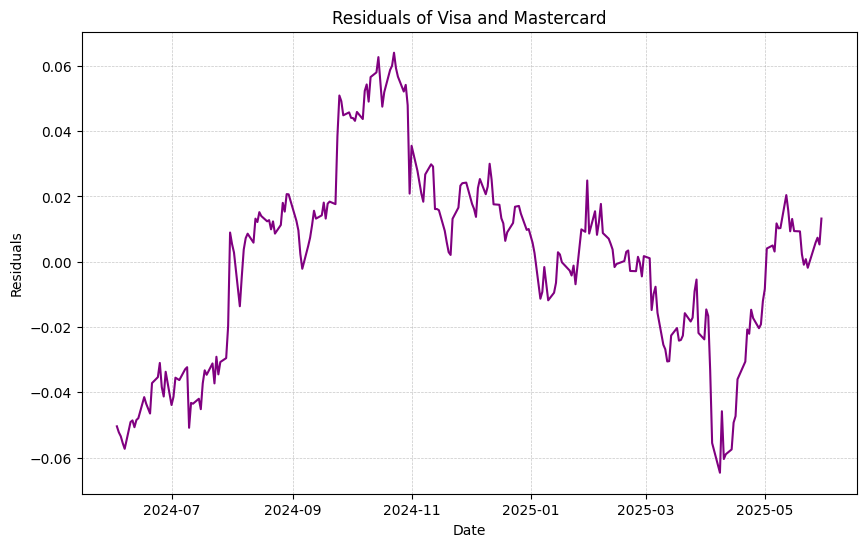

In [15]:
# Function to plot residuals.
def plot_residuals(residuals, pair, data):

    # Plot residuals to visualize the relationship between the two stocks.
    stocka, stockb = pair
    namea, nameb = get_stock_names(pair)
    plt.figure(figsize=(10, 6))

    # Enter residuals into dataframe, to display dates on plot.
    df_residuals = pd.Series(residuals, index=data.index)
    plt.plot(df_residuals, label='Residuals', color='purple')
    plt.title(f'Residuals of {namea} and {nameb}')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()
    plt.close()

# Plot the residuals of the normalized pair of stocks.
plot_residuals(residuals, pair, df)

In [16]:
# Test residuals for stationarity.
# 
# Enter and clean residuals into a dataframe.
df_clean = pd.DataFrame({
    'residual': residuals,
    'residual_lag': residuals_lag,
    'residual_diff': residuals_diff
}).dropna().reset_index(drop=True)

# Greedy implementation of basic ADF test with no lag, no constant, and no trend.
def basic_adfuller(df):
    X = df['residual_lag'].to_numpy().reshape(-1, 1)
    Y = df['residual_diff'].to_numpy().reshape(-1, 1)
    XtX = X.T @ X
    XtY = X.T @ Y
    gamma_hat = XtY / XtX
    y_pred = X * gamma_hat
    errors = Y - y_pred
    RSS = 0
    for err in errors:
        RSS += err ** 2
    n = 0
    for i in X:
        n += 1
    sigma2 = RSS / (n - 1)
    sum_xsq = 0
    for x in X:
        sum_xsq += x ** 2
    var_gamma = sigma2 / sum_xsq
    se_gamma = var_gamma ** 0.5
    gamma_hat_scalar = gamma_hat[0, 0]
    t_stat = gamma_hat_scalar / se_gamma
    print("Basic ADF T-statistic:", t_stat)

    # Approximate p-value using an approximation error function. 
    def erf(x):
        sign = 1 if x >= 0 else -1
        x = abs(x)
        t = 1.0 / (1.0 + 0.3275911 * x)
        a1, a2, a3, a4, a5 = 0.254829592, -0.284496736, 1.421413741, -1.453152027, 1.061405429
        y = 1.0 - (((((a5 * t + a4) * t + a3) * t + a2) * t + a1) * t) * np.exp(-x * x)
        return sign * y
    p_value = 1 - erf(abs(t_stat) / np.sqrt(2))
    print("Basic ADF p-value:", p_value)

basic_adfuller(df_clean)

# Compare basic ADF test with statsmodels ADF test for p-value and statistic.
residual_series = df_clean["residual"]
result = adfuller(residual_series, regression='n', maxlag=0)
print("\nStatsmodels ADF T-statistic:", result[0])

# If p-value < 0.05, we reject the null hypothesis of non-stationarity.
# Therefore, the residuals are stationary, and thus, the original pair is cointegrated.
print("Statsmodels p-value:", result[1])

Basic ADF T-statistic: [-2.22520813]
Basic ADF p-value: [0.02606718]

Statsmodels ADF T-statistic: -2.2655698332361003
Statsmodels p-value: 0.022581847862909156


# Utilize pairs trading methods to find optimal pairs trading strategy.  *** TO BE COMPLETED

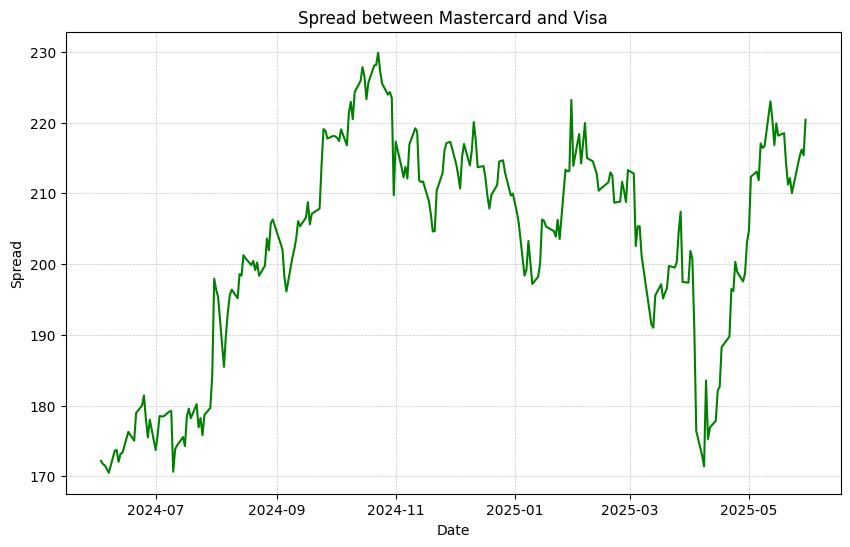

In [17]:
# Function to plot the spread between the two stocks in the pair.
def plot_spread(data, pair):

    # Calculate and plot the spread between the two stocks in the pair.
    data['spread'] = data[pair[1]] - data[pair[0]]

    # Get the names of the stocks in the pair.
    stocka, stockb = pair
    namea, nameb = get_stock_names(pair)

    # Plot spread.
    plt.figure(figsize=(10, 6))
    plt.plot(data['spread'], label=f'Spread: {nameb} - {namea}', color='green')
    plt.title(f'Spread between {nameb} and {namea}')
    plt.xlabel('Date')
    plt.ylabel('Spread')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()
    plt.close()

# Plot the spread.
plot_spread(df, pair)

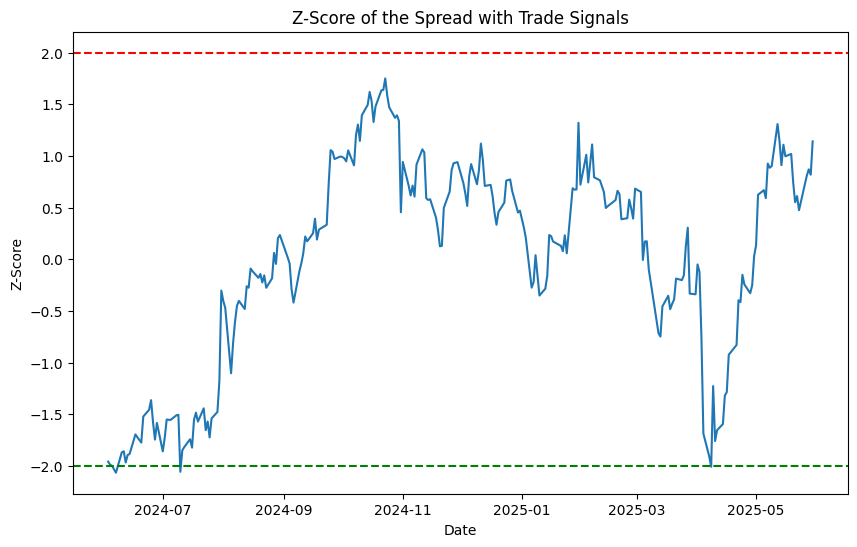

In [18]:
# Function to plot the z-score of the spread.
def plot_zscore(data):

    # Define z-score to normalize the spread.
    data['zscore'] = ((data['spread'] - mean(data['spread'])) / stddev(data['spread']))

    # Set thresholds for entering and exiting trades.
    upper_threshold = 2
    lower_threshold = -2

    # Generate signals for long and short positions.
    for n in range(length(data)):
        z = data['zscore'].iloc[n]
        if z > upper_threshold:
            data.loc[data.index[n], 'pos'] = -1  # Short the spread.
        elif z < lower_threshold:
            data.loc[data.index[n], 'pos'] = 1   # Long the spread.
        elif -1 < z < 1:
            data.loc[data.index[n], 'pos'] = 0   # Exit.

    # Plot z-score.
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['zscore'], label='Z-Score')
    plt.axhline(upper_threshold, color='red', linestyle='--', label='Upper Threshold')
    plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
    plt.title('Z-Score of the Spread with Trade Signals')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.show()
    plt.close()

# Plot the z-score of the spread.
plot_zscore(df)

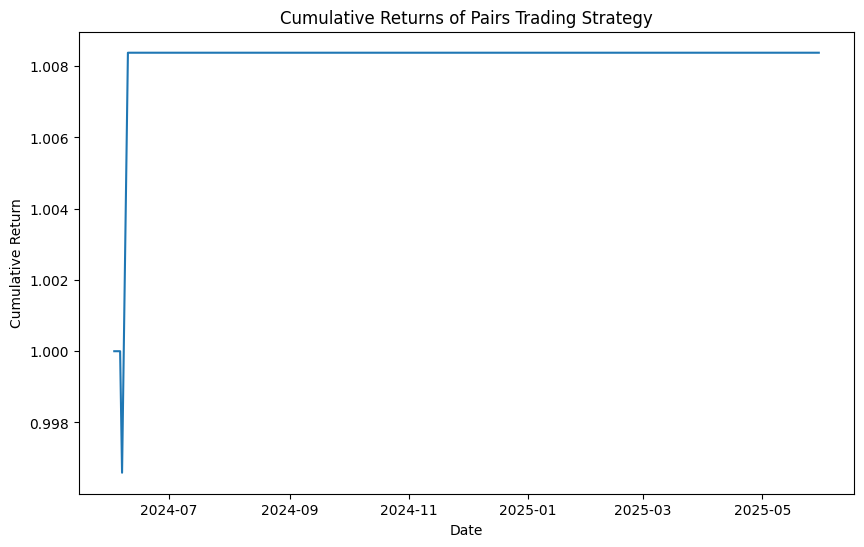

In [19]:
# Function to plot the cumulative returns of the pairs trading strategy.
def plot_cumulative_returns(data, pair):
    
    # Compute daily returns for each stock in the pair.
    data[f'{pair[1]}_return'] = (data[pair[1]] - data[pair[1]].shift(1)) / data[pair[1]].shift(1)
    data[f'{pair[0]}_return'] = (data[pair[0]] - data[pair[0]].shift(1)) / data[pair[0]].shift(1)

    # Strategy returns.
    data['strategy_return'] = data['pos'].shift(1) * (data[f'{pair[1]}_return'] - data[f'{pair[0]}_return'])

    # Cumulative returns.
    cumulative_return = []
    prod = 1
    for ret in data['strategy_return'].fillna(0):
        prod *= (1 + ret)
        cumulative_return.append(prod)
    data['cumulative_return'] = cumulative_return

    # Plot cumulative returns.
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['cumulative_return'], label='Cumulative Return from Strategy')
    plt.title('Cumulative Returns of Pairs Trading Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()
    plt.close()

# Plot the cumulative returns of the pairs trading strategy.
plot_cumulative_returns(df, pair)

In [20]:
# Function to return the sharpe ratio and max drawdown of the pairs trading strategy.
def sharpe_maxdrawdown(data):
    
    # Calculate sharpe ratio.
    count = 0
    total = 0
    for n in data['strategy_return']:
        if not pd.isna(n):
            total += n
            count += 1
    strategy_return_mean = total / count
    sum_sq = 0
    mean_val = strategy_return_mean
    count = 0
    for n in data['strategy_return']:
        if not pd.isna(n):
            sum_sq += (n - mean_val) ** 2
            count += 1
    strategy_return_std = (sum_sq / (count - 1)) ** 0.5
    sharpe_ratio = strategy_return_mean / strategy_return_std * (length(data) ** 0.5)
    print(f"Sharpe Ratio: {sharpe_ratio}")

    # Calculate max drawdown.
    cumulative_max = []
    current_max = data['cumulative_return'].iloc[0]
    for n in data['cumulative_return']:
        if n > current_max:
            current_max = n
        cumulative_max.append(current_max)
    cumulative_max = pd.Series(cumulative_max, index=data.index)
    drawdown = (cumulative_max - data['cumulative_return']) / cumulative_max
    max_drawdown = 0
    for n in drawdown:
        if n > max_drawdown:
            max_drawdown = n
    print(f"Max Drawdown: {max_drawdown}")

# Return the sharpe ratio and max drawdown of the pairs trading strategy.
sharpe_maxdrawdown(df)

Sharpe Ratio: 1.6105412181703653
Max Drawdown: 0.0034095759100331025
